#Multiple products and stochastic environment

Parameters :

*   T rounds
*   N number of types of products
*   P set of possible prices
*   B prduction capacity



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx # we will use it mostly for visualization
from scipy.optimize import linear_sum_assignment
from scipy.optimize import milp
from scipy import optimize
from scipy.sparse.csgraph import shortest_path

In [2]:
num_products = 3
num_prices = 5
n_customers = 20
T = 10000
I = 250000
n_trials = 10

# List of products
# products = ["Laptop", "Mouse", "Keyboard", "Smartphone", "Headphones"]
# costs = [800.00, 10.50, 20.00, 200.00, 50.00]

products = ["Pencil", "Rubber", "Notebook"]
costs = [0.50, 0.10, 1.00]

prices = [ 0.10, 0.70, 1.20, 2.00, 5.00]

# profit matrix
W = np.zeros((num_products, num_prices))
for i, cost in enumerate(costs):
    for j, price in enumerate(prices):
        profit = price - cost
        if W[i, j] < profit:
           W[i, j] = profit if profit > 0 else -999

In [3]:
alpha = {
    "Pencil": 3.0,      # r ≈ 1
    "Rubber":  8.0,      # r ≈ 0.4
    "Notebook": 3.0,    # r ≈ 2
    # "Smartphone": 4.2,     # r ≈ 440
    # "Headphones": 5.0   # r ≈ 150
}

# Build reservation prices r_i
r = np.array([alpha[name] * c for name, c in zip(products, costs)], dtype=float)

p_max = 0.95  # cap max conversion

def conversion_probability(i, price):
    c_i, r_i = costs[i], r[i]
    # Handle degenerate case if r_i <= c_i (force a tiny spread)
    if r_i <= c_i:
        r_i = c_i + 1e-6
    if price <= c_i:
        return 0.95
    if price >= r_i:
        return 0.0
    # Linear decay from c_i (p_max) to r_i (0)
    return p_max * (r_i - price) / (r_i - c_i)
X  = np.zeros((num_products, num_prices))
for i in range(num_products):
    for j in range(num_prices):
        X[i, j] = conversion_probability(i, prices[j]) * n_customers

print(X)

[1.5 0.8 3. ]
[[19.         15.2         5.7         0.          0.        ]
 [19.          2.71428571  0.          0.          0.        ]
 [19.         19.         17.1         9.5         0.        ]]


In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_weighted_matching_custom(matching, W, prd, prc, with_zeros=False):
    """
    matching : list of (i,j) pairs, indices of matched product i to price j
    W        : weight matrix (products x prices)
    prd      : list of product names (len = W.shape[0])
    prc      : list of price names/labels (len = W.shape[1])
    with_zeros : if True, show edges with weight 0 too
    """
    B = nx.Graph()

    # add product nodes (left side of bipartite)
    B.add_nodes_from(prd, bipartite=0)

    # add price nodes (right side of bipartite)
    B.add_nodes_from(prc, bipartite=1)

    # add edges with weights
    for i, j in matching:
        if with_zeros or W[i, j] > 0:
            B.add_edge(prd[i], prc[j])

    # bipartite layout: fix product side
    pos = nx.drawing.layout.bipartite_layout(B, prd)

    # draw graph
    nx.draw_networkx(B, pos=pos, width=2, with_labels=True, node_size=2000, node_color="lightblue")

    # draw edge labels with weights
    edge_labels = nx.get_edge_attributes(B, "weight")
    nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

    plt.show()

In [5]:
def precomputed_realizations(products, prices, T, W):
  x = np.zeros((T,W.shape[0],W.shape[1]))
  for i, product in enumerate(products):
          for j, price in enumerate(prices):
              p = conversion_probability(i, price)  # compute conversion probability for this product-price
              x[:, i, j] = np.random.binomial(n=n_customers, p=p, size=T)

  return x

In [6]:
realization = precomputed_realizations(products, prices, T, W)

In [7]:
class BernoulliMatchingEnv:
    def __init__(self, W, T, costs, prices, n_customers, I, realization):
        self.W = W
        self.I = I
        self.n_customers = n_customers
        self.costs = np.array(costs)
        self.price_values = np.array(prices)
        # we can generate the realization in advance
        self.realizations = realization
        self.t = 0

    def print_Real(self):
        print(self.realizations)

    def round(self, matching):
        """
        matching: list of (product_index, price_index) tuples
        Reward is computed as profit = (price - cost[product]) * demand
        Demand is sampled from Bernoulli conversion probabilities.
        If price == -1, demand and reward are set to 0.
        """
        products, prices = list(zip(*matching))
        products = np.array(products)
        prices   = np.array(prices)

        # Initialize demand and reward as zeros
        d_t = np.zeros(len(products), dtype=int)
        r_t = np.zeros(len(products), dtype=float)

        # Mask for valid prices
        valid_mask = prices != -1

        if np.any(valid_mask):
            # Conversion probabilities for valid entries
            d_valid = self.realizations[self.t][products[valid_mask], prices[valid_mask]]

            # Compute profits: (price_value - cost) * demand
            r_valid = np.maximum(
                (self.price_values[prices[valid_mask]] - self.costs[products[valid_mask]]) * d_valid,
                0
            )

            # Assign back to full arrays
            d_t[valid_mask] = d_valid
            r_t[valid_mask] = r_valid

        self.t += 1
        return d_t, r_t

In [8]:
from scipy import optimize


class CombinatorialUCB:
    def __init__(self, N, P, B, T):
        """
        N: number of products
        P: number of prices
        B: shared capacity (not used right now)
        """
        self.N = N
        self.P = P
        self.B = B
        self.remaining_inventory = B
        self.T = T
        self.counts = np.zeros((N, P))  # times each arm is chosen
        self.means = np.zeros((N, P))   # estimated mean rewards
        self.avg_c = np.zeros((N, P))
        self.t = 0

    def pull_arm(self):
        prices = []

        # If inventory exhausted, sell nothing
        if self.remaining_inventory < 1:
            prices = [-1] * self.N
            return prices

        if self.t < self.P:
            prices = [self.t % self.P] * self.N
            return prices

        f_ucbs = self.means + np.sqrt(2*np.log(self.t + 1)/(self.counts + 1e-6))
        c_lcbs = self.avg_c - np.sqrt(2*np.log(self.t + 1)/(self.counts + 1e-6))

        rho = self.remaining_inventory / max(1, self.T - self.t)

        # compute LP to get probabilities over product/price pairs
        gamma = self.compute_opt(f_ucbs, c_lcbs, rho)

        for i in range(self.N):
            probs = np.clip(gamma[i], 0, None)
            probs /= probs.sum()

            price_idx = np.random.choice(len(probs), p=probs)

            # If the sampled index is 0, treat it as "do not sell"
            if price_idx == 0:
                prices.append(-1)
            else:
                prices.append(price_idx - 1)  # shift back to match original price indices

        return prices


    def compute_opt(self, f_ucbs, c_lcbs, rho):
        """
        Args:
        f_ucbs: (N x P) upper confidence bounds on expected rewards
        c_lcbs: (N x P) lower confidence bounds on expected consumptions
        rho: per-round budget (remaining_inventory / remaining_time)

        Returns:
            gamma: (N x (P+1)) array of probabilities over price choices
        """
        N, P = self.N, self.P

        # Add dummy price (0 reward, 0 cost) as first column (it's equivalent to "do not sell")
        f_ucbs = np.hstack([np.zeros((N, 1)), f_ucbs])
        c_lcbs = np.hstack([np.zeros((N, 1)), c_lcbs])

        # Objective: maximize expected reward
        c_obj = -f_ucbs.flatten()

        # Bounds: gamma_ij >= 0
        bounds = (0, 1)

        # Equality constraints: sum of each row = 1
        A_eq = np.zeros((N, N * (P + 1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(P + 1):
                A_eq[i, i * (P + 1) + j] = 1

        # Inequality constraint: expected cost <= rho
        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]

        res = optimize.linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

        if res.success:
            gamma = res.x.reshape(N, P + 1)
        else:
            gamma = np.zeros((N, P + 1))

        return gamma



    def update(self, prices, demand, rewards):
        """
        prices: list of chosen price indices per product (-1 if product not sold)
        demand: list of units sold per product
        rewards: observed per-product reward
        """
        self.t += 1

        for i in range(self.N):
            p = prices[i]
            if p == -1:
                continue  # product not sold, skip

            units_sold = demand[i]

            # Update inventory
            self.remaining_inventory -= units_sold
            if self.remaining_inventory < 0:
                self.remaining_inventory = 0  # inventory can't go negative

            # Update estimated mean reward for this product/price pair
            self.counts[i, p] += 1
            n = self.counts[i, p]
            self.means[i, p] += (rewards[i] - self.means[i, p]) / n

            self.avg_c[i, p] += (units_sold - self.avg_c[i, p]) / n



In [9]:
import numpy as np

def realized_clairvoyant(realizations, prices, costs, n_customers, B, T):
    """
    realizations : array [T, N, P] with conversion probabilities
    prices       : list of price values (len = P)
    costs        : list of costs (len = N)
    n_customers  : customers per round
    B            : total inventory
    T            : horizon
    Returns:
        total_reward : total profit over horizon
        reward_per_rounds : list of total profit per round
    """
    N, P = len(costs), len(prices)
    total_reward, B_left = 0, B
    reward_per_rounds = []

    for t in range(T):
        if B_left <= 0:
            reward_per_rounds.append(0)
            continue
        else :
            round_reward = 0

            # for each product, pick the best price
            for i in range(N):
                best_j = None
                best_profit = -np.inf
                for j in range(P):
                    demand = realizations[t][i, j]
                    unit_profit = prices[j] - costs[i]
                    profit = unit_profit * demand
                    #print(f"product"+ str(i)+ "with price :"+ str(prices[j])+ "with demand :"+ str(demand)+ "profiti "+str(profit))
                    if profit > best_profit:
                        best_profit = profit
                        best_j = j

                if best_profit > 0:
                    #print(f"product"+ str(i)+ "with price :"+ str(best_j)+ "with profit :"+ str(best_profit))
                    round_reward += best_profit
                    # B_left -= realizations[t][i, best_j]  # each product "consumes" as much inventory units as the demand

                    # if B_left <= 0:
                    #     break  # stop if inventory exhausted

            reward_per_rounds.append(round_reward)
            total_reward += round_reward

    return total_reward, reward_per_rounds


In [10]:
clairvoyant_total_reward, clay_per_round = realized_clairvoyant(realization, prices, costs, n_customers, I, T)
print(clairvoyant_total_reward)

153466.5000000002
10000


In [11]:
# deterministic clairvoyant
best_pairs = np.zeros((num_products, 2))

for i in range(num_products):
    best_reward = 0
    for j in range(num_prices):
        expected = W[i, j] * conversion_probability(i, prices[j]) * n_customers

        if expected > best_reward:
            # found a strictly better reward → reset list
            best_reward = expected
            best_pairs[i, 0] = i
            best_pairs[i, 1] = j

clairvoyant_matching = list(best_pairs)

Trail 0 Round  1
  Agent prices:  [0, 0, 0]
  Demand:        [19 18 19]
  Remaining B:   249944
  Agent Rewards:       [0. 0. 0.]
  Clay Rewards:       10.7
  TOT Agent Rewards:       0.0
Trail 0 Round 21
  Agent prices:  [2, 1, 3]
  Demand:        [ 9  0 11]
  Remaining B:   249562
  Agent Rewards:       [ 6.3  0.  11. ]
  Clay Rewards:       17.3
  TOT Agent Rewards:       17.3
Trail 0 Round 41
  Agent prices:  [2, 2, 3]
  Demand:        [ 3  0 12]
  Remaining B:   249207
  Agent Rewards:       [ 2.1  0.  12. ]
  Clay Rewards:       15.799999999999999
  TOT Agent Rewards:       14.1
Trail 0 Round 61
  Agent prices:  [2, 1, 3]
  Demand:        [ 6  3 11]
  Remaining B:   248811
  Agent Rewards:       [ 4.2  1.8 11. ]
  Clay Rewards:       17.0
  TOT Agent Rewards:       17.0
Trail 0 Round 81
  Agent prices:  [2, 1, 3]
  Demand:        [ 8  1 11]
  Remaining B:   248422
  Agent Rewards:       [ 5.6  0.6 11. ]
  Clay Rewards:       17.2
  TOT Agent Rewards:       17.2
Trail 0 Round 101


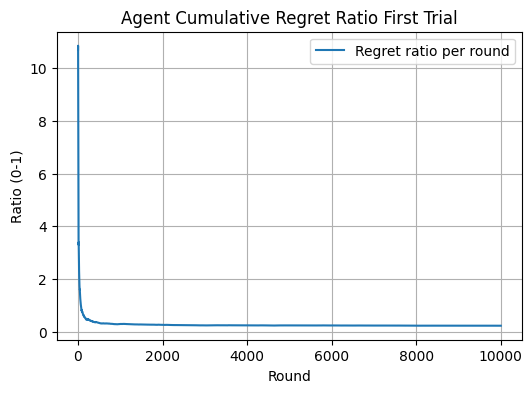

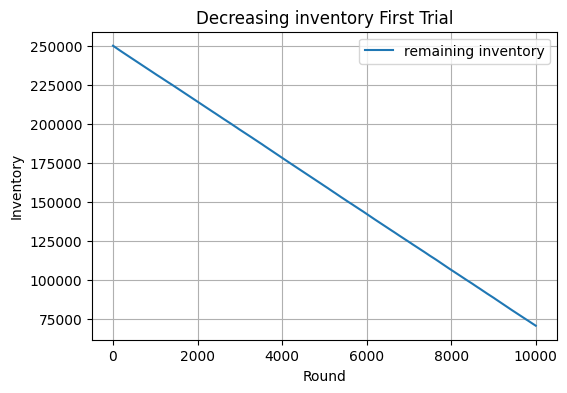

=== Final Results Trail 0 ===
Total agent reward:       150802.60
Deterministic clairvoyant reward: 153135.70
Total regret:             2333.10
Average regret ratio:     0.277
=== Final Results Trail 1 ===
Total agent reward:       151159.90
Deterministic clairvoyant reward: 153522.00
Total regret:             2362.10
Average regret ratio:     0.288
=== Final Results Trail 2 ===
Total agent reward:       151550.40
Deterministic clairvoyant reward: 153888.50
Total regret:             2338.10
Average regret ratio:     0.282
=== Final Results Trail 3 ===
Total agent reward:       151029.60
Deterministic clairvoyant reward: 153324.30
Total regret:             2294.70
Average regret ratio:     0.290
=== Final Results Trail 4 ===
Total agent reward:       151296.20
Deterministic clairvoyant reward: 153615.20
Total regret:             2319.00
Average regret ratio:     0.281
=== Final Results Trail 5 ===
Total agent reward:       151403.40
Deterministic clairvoyant reward: 153793.60
Total regr

In [16]:
last = []
l_agent = 0
overtrials_agentreward = 0
overtrials_clay = 0
overtrials_regret = 0
overtrials_avgregret = 0
np.random.seed(32)
W = np.random.rand(num_products, num_prices)

for i in range(n_trials):
    realization = precomputed_realizations(products, prices, T, W)
    clairvoyant_total_reward, clay_per_round = realized_clairvoyant(realization, prices, costs, n_customers, I, T)


    env = BernoulliMatchingEnv(W, T, costs, prices, n_customers, I, realization)
    agent = CombinatorialUCB(
        N=len(products),
        P=len(prices),
        B=I,                  # shared capacity
        T=T
    )

    agent_rewards = np.array([])
    agent_superarms = []

    history_agent_rewards = []
    regret_ratio_per_round = []
    cumulative_regret = 0
    rem_inventory = []

    for t in range(T):
        prices_agent = agent.pull_arm()

        # Construct the matching list in the correct format (product_index, price_index)
        matching_for_env = []
        for product_idx, price_idx in enumerate(prices_agent):
            matching_for_env.append((product_idx, price_idx))

        demand_agent, rewards_agent = env.round(matching_for_env)
        agent.update(prices_agent, demand_agent, rewards_agent)

        history_agent_rewards.append(rewards_agent.sum())  # Sum the rewards for the round
        rem_inventory.append(agent.remaining_inventory)

        diff = clay_per_round[t] - rewards_agent.sum()
        cumulative_regret += diff

        regret_ratio_per_round.append(
            (cumulative_regret / (t + 1))
        )

        if i == 0 and t % 20 == 0 :
          print(f"Trail {i} Round {t+1:2d}")
          print(f"  Agent prices:  {prices_agent}")
          print(f"  Demand:        {demand_agent}")
          print(f"  Remaining B:   {agent.remaining_inventory}")
          print(f"  Agent Rewards:       {rewards_agent}")
          print(f"  Clay Rewards:       {clay_per_round[t]}")
          print(f"  TOT Agent Rewards:       {rewards_agent.sum()}")

        if t == 0 or rewards_agent.sum() > l_agent:
            last = prices_agent
            l_agent = rewards_agent.sum()

    # Final comparison
    total_agent_reward = sum(history_agent_rewards)
    total_regret = clairvoyant_total_reward - total_agent_reward
    avg_ratio = np.sum(regret_ratio_per_round) / len(regret_ratio_per_round)

    if i == 0 :
      plt.figure(figsize=(6,4))
      plt.plot(range(1, T+1), regret_ratio_per_round, label='Regret ratio per round')
      plt.xlabel("Round")
      plt.ylabel("Ratio (0-1)")
      plt.title("Agent Cumulative Regret Ratio First Trial")
      plt.grid(True)
      plt.legend()
      plt.show()

      plt.figure(figsize=(6,4))
      plt.plot(range(1, T+1), rem_inventory, label='remaining inventory')
      plt.xlabel("Round")
      plt.ylabel("Inventory")
      plt.title("Decreasing inventory First Trial")
      plt.grid(True)
      plt.legend()
      plt.show()

    print(f"=== Final Results Trail {i} ===")
    print(f"Total agent reward:       {total_agent_reward:.2f}")
    print(f"Deterministic clairvoyant reward: {clairvoyant_total_reward:.2f}")
    print(f"Total regret:             {total_regret:.2f}")
    print(f"Average regret ratio:     {avg_ratio:.3f}")

    overtrials_clay += clairvoyant_total_reward
    overtrials_agentreward += total_agent_reward
    overtrials_regret += total_regret
    overtrials_avgregret += avg_ratio


print("=== Final Results Overall ===")
print(f"Total agent reward:       {overtrials_agentreward:.2f}")
print(f"Deterministic clairvoyant reward: {overtrials_clay:.2f}")
print(f"Total regret:             {overtrials_regret:.2f}")
print(f"Average regret ratio:     {overtrials_avgregret / n_trials:.3f}")

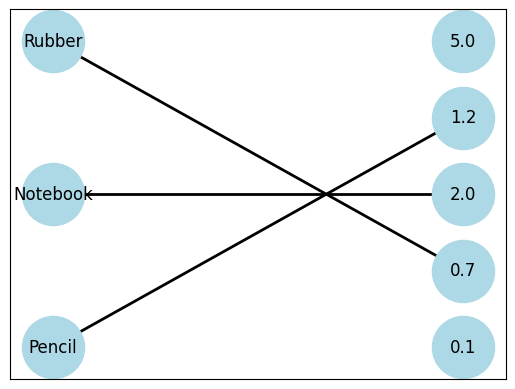

In [14]:
b_pairs = np.zeros((num_products, 2))

for i in range(num_products):
   b_pairs[i,0] = i
   b_pairs[i,1] = last[i]

alg_result = list(b_pairs)
alg_res_int = [(int(i[0]), int(i[1])) for i in alg_result]

plot_weighted_matching_custom(alg_res_int, W, products, prices)